# SkillFactory
## Введение в ML, введение в sklearn

В этом задании мы с вами рассмотрим данные с конкурса [Задача предсказания отклика клиентов ОТП Банка](http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

### Грузим данные

Считаем описание данных

In [2]:

df_descr = pd.read_csv('data/otp_description.txt', sep='\t', encoding='utf8')

In [3]:
# for i in range(df_descr.shape[0]):
#     print(df_descr.iloc[i,0], "-", df_descr.iloc[i,1])

Считаем обучающую выборки и тестовую (которую мы как бы не видим)

In [4]:
df_train = pd.read_csv('data/otp_train.csv', sep='\t', encoding='utf8')

In [5]:
df_train.shape

(15223, 52)

In [6]:
df_test = pd.read_csv('data/otp_test.csv', sep='\t', encoding='utf8')

In [7]:
df_test.shape

(14910, 52)

## Объединим две выборки

Так как пока мы пока не умеем работать sklearn  Pipeline, то для того, чтобы после предобработки столбцы в двух выборках находились на своих местах.

Для того, чтобы в дальнейшем отделить их введем новый столбец "sample"

In [8]:
df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'

In [9]:
df = df_test.append(df_train).reset_index(drop=True)

In [10]:
df.shape

(30133, 53)

In [11]:
p = df.pivot_table(
    'AGREEMENT_RK', 'sample', 'TARGET', 'count')
p

TARGET,0,1
sample,,
test,13160,1750
train,13411,1812


### Чуть-чуть посмотрим на данные

Посмотрим типы данных и их заполняемость

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30133 entries, 0 to 30132
Data columns (total 53 columns):
AGREEMENT_RK                  30133 non-null int64
TARGET                        30133 non-null int64
AGE                           30133 non-null int64
SOCSTATUS_WORK_FL             30133 non-null int64
SOCSTATUS_PENS_FL             30133 non-null int64
GENDER                        30133 non-null int64
CHILD_TOTAL                   30133 non-null int64
DEPENDANTS                    30133 non-null int64
EDUCATION                     30133 non-null object
MARITAL_STATUS                30133 non-null object
GEN_INDUSTRY                  27420 non-null object
GEN_TITLE                     27420 non-null object
ORG_TP_STATE                  27420 non-null object
ORG_TP_FCAPITAL               27425 non-null object
JOB_DIR                       27420 non-null object
FAMILY_INCOME                 30133 non-null object
PERSONAL_INCOME               30133 non-null object
REG_ADDRESS_PRO

Видим, что часть данных - object, скорее всего стоки.


Давайте выведем эти значения для каждого столбца

In [13]:
for i in df_train.columns: # перебираем все столбцы
    if str(df_train[i].dtype) == 'object': # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(df_train[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку

EDUCATION
{'Среднее', 'Два и более высших образования', 'Неполное среднее', 'Неоконченное высшее', 'Ученая степень', 'Среднее специальное', 'Высшее'}


MARITAL_STATUS
{'Гражданский брак', 'Состою в браке', 'Не состоял в браке', 'Разведен(а)', 'Вдовец/Вдова'}


GEN_INDUSTRY
{nan, 'Информационные технологии', 'Маркетинг', 'Наука', 'Юридические услуги/нотариальные услуги', 'Химия/Парфюмерия/Фармацевтика', 'Информационные услуги', 'Туризм', 'Недвижимость', 'Нефтегазовая промышленность', 'ЧОП/Детективная д-ть', 'Коммунальное хоз-во/Дорожные службы', 'Развлечения/Искусство', 'Транспорт', 'Логистика', 'Другие сферы', 'Металлургия/Промышленность/Машиностроение', 'Страхование', 'СМИ/Реклама/PR-агенства', 'Управляющая компания', 'Образование', 'Энергетика', 'Строительство', 'Подбор персонала', 'Торговля', 'Ресторанный бизнес/Общественное питание', 'Салоны красоты и здоровья', 'Сельское хозяйство', 'Государственная служба', 'Банк/Финансы', 'Здравоохранение', 'Сборочные производства'}


GEN_TITLE


Mожно заметить что некоторые переменные, которые обозначены как строки (например PERSONAL_INCOME) на самом деле числа, но по какой-то причине были распознаны как строки

Причина же что использовалась запятая для разделения не целой части числа..

Перекодировать их можно например так:

In [14]:
#df['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float')

Такой эффект наблюдается в столбцах `PERSONAL_INCOME`, `CREDIT`, `FST_PAYMENT`, `LOAN_AVG_DLQ_AMT`, `LOAN_MAX_DLQ_AMT`

### Теперь ваше небольшое исследование

#### Задание 1. Есть ли пропуски в данных? Что с ними сделать?

(единственного верного ответа нет - аргументируйте)

In [15]:
#посчитаем пропуски в данных:
with_null = df.isnull().sum(axis = 0)
with_null[with_null != 0]

GEN_INDUSTRY                   2713
GEN_TITLE                      2713
ORG_TP_STATE                   2713
ORG_TP_FCAPITAL                2708
JOB_DIR                        2713
TP_PROVINCE                     590
REGION_NM                         2
WORK_TIME                      2717
PREVIOUS_CARD_NUM_UTILIZED    29533
dtype: int64

_решение:_ пропуски в данных есть, но способы их заполнения могут зависеть от причин.
для этого рассмотрим пропуски по столбцам отдельно
<br><br>
На сайте сказано, что данные пустые, так как клиенты не заполнили эти поля, но в любом случае нужно проверить на зависимость от других параметром

#### a) Факторы с одинаковым количеством пропусков

У факторов 'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'JOB_DIR' одинаковое количество пропусков. Проверим, находятся ли пропуски в одних и тех же строках. Например, есть ли в этих факторах не пустые значения, если значение 'GEN_INDUSTRY' пустое

In [16]:
df[df['GEN_INDUSTRY'].isnull() == True][['GEN_INDUSTRY',
                                         'GEN_TITLE',
                                         'ORG_TP_STATE',
                                         'JOB_DIR']].isnull().sum(axis = 0)

GEN_INDUSTRY    2713
GEN_TITLE       2713
ORG_TP_STATE    2713
JOB_DIR         2713
dtype: int64

In [17]:
#создадим отдельный df и посмотрим его подробнее
simult_na = df[df['GEN_INDUSTRY'].isnull() == True]
simult_na.head(n = 15).T

,1,5,8,12,20,28,30,57,77,96,103,111,156,177,192
AGREEMENT_RK,59910420,59911769,59912422,59912574,59913432,59914189,59914517,59918446,59920591,59923652,59924499,59924977,59930509,59932751,59935061
TARGET,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AGE,48,44,53,59,65,63,63,62,58,66,59,61,55,59,63
SOCSTATUS_WORK_FL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SOCSTATUS_PENS_FL,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
GENDER,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1
CHILD_TOTAL,0,2,2,0,2,0,2,0,2,0,0,0,4,2,2
DEPENDANTS,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
EDUCATION,Среднее,Среднее специальное,Среднее специальное,Неполное среднее,Среднее специальное,Среднее специальное,Среднее специальное,Среднее специальное,Среднее специальное,Неполное среднее,Среднее специальное,Среднее специальное,Среднее,Среднее,Неполное среднее
MARITAL_STATUS,Состою в браке,Состою в браке,Состою в браке,Не состоял в браке,Разведен(а),Состою в браке,Не состоял в браке,Состою в браке,Вдовец/Вдова,Состою в браке,Не состоял в браке,Разведен(а),Не состоял в браке,Состою в браке,Разведен(а)


In [18]:
#скорее всего, данные не заполнены для всех неработающих и/или пенсионеров.
#посчитаем к-во записей по столбцам SOCSTATUS_WORK_FL и SOCSTATUS_PENS_FL в
#этом же df

p = simult_na.pivot_table(
    'TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'count')
p
#получается, что проблема была в отстутствии данных о работе у неработающих
#пенсионеров. При этом безработные в выборке отсутствуют
#также данных по перечисленным факторам нет для одного 24-летнего.
#Предположим, что это ошибка в данных, тогда пропуск можно заполнить
#самыми частыми значениями для его возрастной группы

SOCSTATUS_PENS_FL,0,1
SOCSTATUS_WORK_FL,,
0,NaN,2712.0
1,1.0,NaN


#### b) Фактор worktime

Похоже, пропуски в worktime тоже связаны с неработающими пенсионерами из предыдущего пункта. Однако пропусков там чуть больше, найдем в чем разница

In [19]:
no_worktime = df[df['WORK_TIME'].isnull() == True]
o_worktime = pd.merge(no_worktime, simult_na, how='outer')
i_worktime = pd.merge(no_worktime, simult_na)
set_diff_worktime = pd.concat([o_worktime, i_worktime]).drop_duplicates(keep=False)
#set_diff_worktime.T #в df 4 записи
#есть 4 человека со статусом безработный пенсионер, у которых есть данные о работодателе
#при этом не заполнены данные по времени работы в текущем месте. в остальном
#этот фактор совпадает с 4 предыдущими

#### c) Фактор ORG_TP_FCAPITAL

In [20]:
#скорее всего, пропуски в этом факторе тоже связаны с отсутствием данных по безработным пенсионерам
#поэтому найдем разницу между двумя df с пропусками в этих факторах

no_capital = df[df['ORG_TP_FCAPITAL'].isnull() == True]
o_capital = pd.merge(no_capital, simult_na, how='outer')
i_capital = pd.merge(no_capital, simult_na)
set_diff_capital = pd.concat([o_capital, i_capital]).drop_duplicates(keep=False)
#set_diff_capital.T #7 записей в df

Два множества отличаются на 7 записей. Будем считать, что причина одинаковая

#### d) Фактор TP_PROVINCE

TP_PROVINCE = область торговой точки, где клиент брал последний кредит
из описания данных на сайте не совсем понятно, какие клиенты "лежат" в датасете. Значит ли это, что клиент не брал кредит или что данных нет по какой-то другой причине (например, кредит был получен не в магазине)?

In [21]:
#проверим есть ли нули в поле CREDIT - это может означать, что в выборке есть клиенты без кредитов,
#тогда для них не будет и торговой точки выдачи кредита.
df[df['CREDIT'] == 0]

#в поле с суммами выданных кредитов нет пропусков и нулей

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,...,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,sample


In [22]:
#в датафрейме кроме TP_PROVINCE есть еще 4 фактора, относящихся к географии,
#и 4 фактора, указывающие на совпадение этих измерений (среди них есть и
#совпадение по отсутствующему полю)
#посмотрим этот набор более подробно:

geo_col_list = ['REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE',
               'TP_PROVINCE', 'REGION_NM', 'REG_FACT_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
               'REG_FACT_POST_TP_FL']

geo_df = df[geo_col_list]
geo_df.head()

,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL
0,Красноярский край,Красноярский край,Красноярский край,Красноярский край,ВОСТОЧНО-СИБИРСКИЙ,0,0,0,1
1,Орловская область,Орловская область,Орловская область,Орловская область,ЦЕНТРАЛЬНЫЙ 1,1,1,1,1
2,Коми,Коми,Коми,Коми,ЦЕНТРАЛЬНЫЙ 2,1,1,1,1
3,Читинская область,Читинская область,Читинская область,Читинская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1
4,Хабаровский край,Хабаровский край,Хабаровский край,Хабаровский край,ДАЛЬНЕВОСТОЧНЫЙ,1,1,1,1


In [23]:
#отдельно посмотрим географические факторы с пропусками в TP_PROVINCE
geo_df = geo_df[geo_df['TP_PROVINCE'].isnull() == True]
geo_df

,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL
40,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
67,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
120,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
282,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,0,0,0,0
315,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
336,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
534,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
537,Москва,Москва,Москва,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
609,Москва,Москва,Москва,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
664,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0


In [24]:
#отдельно посмотрим есть ли в логической переменной REG_FACT_POST_TP_FL для TP_PROVINCE единицы

geo_df[geo_df['REG_FACT_POST_TP_FL'] == 1]

,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL


*Ответ на задание 1:* <br>
пропуски есть. основные группы/факторы/причины:<br>
1. __**проблема:**__ есть пропуски для неработающих пенсионеров в 6 столбцах (и совсем небольшое число пропусков там-же, которые можно списать на ошибки при сборе данных<br>
__**решение:**__ можно сделать отдельный "класс" - неработающий пенсионер
2. __**проблема:**__ 590 пропусков TP_PROVINCE - причина пока не ясна. <br>__**решение:**__ Но есть много других географических данных, можно заполнить данными из одного из них для каждого конкретного клиента. Делаем допущение, что часто они совпадают (нужно проверить!!)
3. __**проблема:**__ PREVIOUS_CARD_NUM_UTILIZED <br>__**решение:**__ согласно описанию данных: пропуск = 0. просто заполним

#### Задание 2. Есть ли категориальные признаки? Что с ними делать?

In [25]:
#чтобы найти категориальные признаки - посмотрим к-во уникальных значений в каждом столбце (без учета nan)
distinct_in_cols = {i : df[i].value_counts(dropna = True).count() for i in df.columns}
distinct_in_cols

{'AGREEMENT_RK': 30133,
 'TARGET': 2,
 'AGE': 47,
 'SOCSTATUS_WORK_FL': 2,
 'SOCSTATUS_PENS_FL': 2,
 'GENDER': 2,
 'CHILD_TOTAL': 10,
 'DEPENDANTS': 8,
 'EDUCATION': 7,
 'MARITAL_STATUS': 5,
 'GEN_INDUSTRY': 31,
 'GEN_TITLE': 12,
 'ORG_TP_STATE': 5,
 'ORG_TP_FCAPITAL': 2,
 'JOB_DIR': 10,
 'FAMILY_INCOME': 5,
 'PERSONAL_INCOME': 373,
 'REG_ADDRESS_PROVINCE': 82,
 'FACT_ADDRESS_PROVINCE': 83,
 'POSTAL_ADDRESS_PROVINCE': 82,
 'TP_PROVINCE': 70,
 'REGION_NM': 11,
 'REG_FACT_FL': 2,
 'FACT_POST_FL': 2,
 'REG_POST_FL': 2,
 'REG_FACT_POST_FL': 2,
 'REG_FACT_POST_TP_FL': 2,
 'FL_PRESENCE_FL': 2,
 'OWN_AUTO': 3,
 'AUTO_RUS_FL': 2,
 'HS_PRESENCE_FL': 2,
 'COT_PRESENCE_FL': 2,
 'GAR_PRESENCE_FL': 2,
 'LAND_PRESENCE_FL': 2,
 'CREDIT': 12911,
 'TERM': 23,
 'FST_PAYMENT': 4655,
 'DL_DOCUMENT_FL': 1,
 'GPF_DOCUMENT_FL': 2,
 'FACT_LIVING_TERM': 525,
 'WORK_TIME': 372,
 'FACT_PHONE_FL': 2,
 'REG_PHONE_FL': 2,
 'GEN_PHONE_FL': 2,
 'LOAN_NUM_TOTAL': 9,
 'LOAN_NUM_CLOSED': 10,
 'LOAN_NUM_PAYM': 88,
 'LOAN

In [26]:
#1) в выдорке есть категориальные признаки, уже закодированные в приемлемом для обучения модели виде (1-0):
already_binary = ['AUTO_RUS_FL', 'COT_PRESENCE_FL', 'FL_PRESENCE_FL', 'GAR_PRESENCE_FL', 'GENDER', 'GEN_PHONE_FL',
                 'GPF_DOCUMENT_FL', 'HS_PRESENCE_FL', 'LAND_PRESENCE_FL',
                 'REG_FACT_FL', 'REG_FACT_POST_FL', 'REG_FACT_POST_TP_FL', 'REG_PHONE_FL', 'REG_POST_FL',
                 'SOCSTATUS_PENS_FL', 'SOCSTATUS_WORK_FL', 'FACT_PHONE_FL']

#2) список категориальных признаков, которые будем кодировать one-hot:
category_vars = ['EDUCATION', 'FAMILY_INCOME', 'ORG_TP_STATE']

#непонятно LOAN_MAX_DLQ - номер просрочки качественный или нет

1. Категориальные признаки с "небольшим" к-вом уникальных значений закодируем one-hot.
2. Категориальные признаки, связанные с работой, закодируем численно (средний доход и возраст для отрасли, позиции и тд)
3. Географию закодируем как средний доход по месту проживания, остальные "текстовые" поля удалим, оставим бинарные переменные, которые говорят о совпадении разных адресов клиента

#### Задание 3. Фунция предобработки

Напишите функцию, которая бы

* Удаляло идентификатор `AGREEMENT_RK`
* Избавлялась от проблем с '.' и ',' в стобцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT
* Что-то делала с пропусками
* Кодировала категориальные признаки

В результате, ваш датафрейм должен содержать только числа и не содержать пропусков!

In [27]:
from sklearn.preprocessing import StandardScaler

#спасибо SO
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

def code_median(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].median()))

def preproc_data(df_input):
    df_output = df_input.copy()
    
    #replace decimal sign
    
    lst_dec_repl = ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']
    
    for i in lst_dec_repl:
        df_output[i] = df_output[i].map(lambda x: x.replace(',', '.')).astype('float32')
        
    #нужно скорректировать отрицательные месяца и клиентов, которые
    #веками (судя по данным) живут на одном месте. для них делаем 
    #допущение - всю жизь живет там же
    df_output.loc[df_output['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    for index, row in df_output.iterrows():
        if row['FACT_LIVING_TERM']/12 > row['AGE']:
            row['FACT_LIVING_TERM'] > row['AGE']*12
    
    #есть люди, проработавшие на последнем месте больше своего возраста или
    #люди, которые начали работать в 10 лет (судя по разнице текущего возраста
    #и стажа на последнем месте). Предположим, самое раннее человек начал работать с 15:
    for index, row in df_output.iterrows():
        if np.isnan(row['WORK_TIME']) == False:
            if (row['WORK_TIME']/12 > (row['AGE']-15)):
                row['WORK_TIME'] = (row['AGE']-15)*12
    
    #заполняем пропуски
    
    #заполим пропуски для неработающих пенсионеров
    subs_list = ['GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL',
            'JOB_DIR']

    df_output.loc[(df_output['SOCSTATUS_PENS_FL'] == 1)
           & (df_output['SOCSTATUS_WORK_FL'] == 0)
           & (df_output['GEN_INDUSTRY'].isnull() == True), subs_list] = 'unemp_pens'
    
    #после этого останется еще один человек с пропусками в этих полях
    #но в этом случае это скорее всего ошибка, поэтому заполним его
    #пропуски самым частым значением для возраста до 31
    dic_modes = {i : df_output.loc[:,i][df_output['AGE'] <= 30].value_counts().idxmax() for i in subs_list}
    
    for k, v in dic_modes.items():
        df_output.loc[df_output['AGREEMENT_RK'] == 64469089, k] = dic_modes[k]
    
    #заполняем последний пропуск в ORG_TP_FCAPITAL
    df_output.loc[df_output['ORG_TP_FCAPITAL'].isnull() == True, 'ORG_TP_FCAPITAL'] = df_output.loc[:,'ORG_TP_FCAPITAL'].value_counts().idxmax()
    
    #заполняем пропуски в REGION_NM и TP_PROVINCE из соседних столбцов (для остальных все совпадает)
    df_output['REGION_NM'] = df_output['REGION_NM'].fillna(df_output['TP_PROVINCE'])
    df_output['TP_PROVINCE'] = df_output['TP_PROVINCE'].fillna(df_output['FACT_ADDRESS_PROVINCE'])
    
    #заполняем WORK_TIME (уже после удаления "выбросов")
    df_output['WORK_TIME'] = df_output['WORK_TIME'].fillna(df_output['WORK_TIME'].median())
    
    
    #кодируем категориальные пременные
    #укрупним и переименуем ряд признаков
    dict_educ = {'Среднее специальное':'mid',
             'Среднее':'mid',
             'Высшее':'higher',
             'Неполное среднее':'higher',
             'Неоконченное высшее':'mid',
             'Два и более высших образования':'higher',
             'Ученая степень':'phd'}

    dict_fam_inc = {'от 10000 до 20000 руб.':'10_20',
                    'от 20000 до 50000 руб.':'20_50',
                    'от 5000 до 10000 руб.':'5_10',
                    'свыше 50000 руб.':'50_gr',
                    'до 5000 руб.':'5_less'}
    
    dict_mar_stat = {'Состою в браке':'couple',
                    'Гражданский брак':'couple',
                    'Разведен(а)':'single',
                    'Не состоял в браке':'single',
                    'Вдовец/Вдова':'single'}
    
    dict_comp_type = {'Государственная комп./учреж.':'state',
                     'Частная компания':'private_loc',
                     'Индивидуальный предприниматель':'entrep',
                     'Некоммерческая организация':'nfp',
                     'Частная ком. с инос. капиталом':'private_glob'}

    df_output['EDUCATION'].replace(dict_educ, inplace=True) #укрупняем и делаем one hot
    df_output['FAMILY_INCOME'].replace(dict_fam_inc, inplace=True) #переводим и делаем one hot
    df_output['MARITAL_STATUS'].replace(dict_mar_stat, inplace=True) #укрупняем чтобы сделать бинарным
    df_output['MARITAL_STATUS'].replace({'single':0, 'couple':1}, inplace=True) 
    df_output['ORG_TP_STATE'].replace(dict_comp_type, inplace=True) #переводим
    df_output['ORG_TP_FCAPITAL'].replace({'Без участия':0, 'С участием':1, 'unemp_pens':0}, inplace=True) #делаем бинарным
    
    scaler = StandardScaler()
    df_output[['PERSONAL_INCOME']] = scaler.fit_transform(df_output[['PERSONAL_INCOME']])
    df_output[['WORK_TIME']] = scaler.fit_transform(df_output[['WORK_TIME']])
    
    #географию "закодируем" медианным личным доходом в области фактического проживания клиента
    #и 2 бинарными переменными: REG_FACT_POST_FL и REG_FACT_POST_TP_FL (остальные удалим)
    df_output['FACT_PROV_INC'] = code_median(df_output, 'FACT_ADDRESS_PROVINCE', 'PERSONAL_INCOME')
    df_output['GEN_INDUSTRY_INC'] = code_mean(df_output, 'GEN_INDUSTRY', 'PERSONAL_INCOME')
    df_output['GEN_TITLE_AGE'] = code_mean(df_output, 'GEN_TITLE', 'AGE')
    df_output['JOB_DIR_WORK'] = code_mean(df_output, 'JOB_DIR', 'WORK_TIME')
    df_output['GEN_INDUSTRY_SIZE'] = df_output['GEN_INDUSTRY'].map(df_output.groupby('GEN_INDUSTRY').size())
    df_output['GEN_TITLE_SIZE'] = df_output['GEN_TITLE'].map(df_output.groupby('GEN_TITLE').size())
    df_output['JOB_DIR_SIZE'] = df_output['JOB_DIR'].map(df_output.groupby('JOB_DIR').size())
            
    lst_scale = ['CREDIT','GEN_INDUSTRY_SIZE', 'GEN_TITLE_SIZE','JOB_DIR_SIZE',
                 'FST_PAYMENT', 'FACT_LIVING_TERM', 'LOAN_MAX_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']
    
    df_output[lst_scale] = scaler.fit_transform(df_output[lst_scale])
    
    #удаляем категориальные факторы, которые мы перекодировали числами
    df_output = df_output.drop(['POSTAL_ADDRESS_PROVINCE',
                                'REGION_NM',
                                'REG_ADDRESS_PROVINCE',
                                'TP_PROVINCE',
                                'FACT_ADDRESS_PROVINCE',
                                'GEN_INDUSTRY',
                                'GEN_TITLE',
                                'JOB_DIR'], axis=1)
    
    df_output = pd.get_dummies(df_output, columns=category_vars)
    
    #поле заполняем согласно текстовому описанию (пусто = 0)
    df_output['PREVIOUS_CARD_NUM_UTILIZED'] = df_output['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0)
    
    #удаляем лишние столбцы
    df_output.drop('AGREEMENT_RK', axis=1, inplace=True)
    df_output.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

    return df_output

In [28]:
df_preproc = df.pipe(preproc_data)

df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

#### Задание 4. Отделите целевую переменную и остальные признаки

Должно получится:
* 2 матрицы: X и X_test
* 2 вектора: y и y_test

In [29]:
y = df_train_preproc['TARGET']
y_test = df_test_preproc['TARGET']

X = df_train_preproc.drop(['TARGET'], axis=1)
X_test = df_test_preproc.drop(['TARGET'], axis=1)

#### Задание 5. Обучение и оценка качества разных моделей

In [30]:
from sklearn.cross_validation import train_test_split
# test_size=0.3, random_state=42

## Your Code Here
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.3, random_state=42)


C:\Users\andrey\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
# Попробовать следующие "черные ящики": интерфейс одинаковый 
# Постепенно мы узнаем, что они делают а сейчас учимся понимать какой работает качественнее
#     fit, 
#     predict, 
#     predict_proba

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_Train, y_Train)
predict_DTC = model_DTC.predict(X_test)
predict_p_DTC = model_DTC.predict_proba(X_test)

model_RFC = RandomForestClassifier()
model_RFC.fit(X_Train, y_Train)
predict_RFC = model_RFC.predict(X_test) 
predict_p_RFC = model_RFC.predict_proba(X_test) 

model_LR = LogisticRegression()
model_LR.fit(X_Train, y_Train)
predict_LR = model_LR.predict(X_test)
predict_p_LR = model_LR.predict_proba(X_test)

C:\Users\andrey\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [32]:
# Посчитать метрики стандартные
# accuracy, precision, recall

from sklearn.metrics import accuracy_score, precision_score, recall_score

## Your Code Here

metric_names = ['Precision']*3 + ['Recall']*3 + ['Accuracy']*3

d = {'model': ['DTC', 'RFC', 'LR']*3,
     'metric' : metric_names,
     'values': [precision_score(y_test, predict_DTC),
                precision_score(y_test, predict_RFC),
                precision_score(y_test, predict_LR),
                recall_score(y_test, predict_DTC),
                recall_score(y_test, predict_RFC),
                recall_score(y_test, predict_LR),
                accuracy_score(y_test, predict_DTC),
                accuracy_score(y_test, predict_RFC),
                accuracy_score(y_test, predict_LR)]
    }

metrics = pd.DataFrame(data=d)
metrics

,model,metric,values
0,DTC,Precision,0.164814
1,RFC,Precision,0.259615
2,LR,Precision,0.413793
3,DTC,Recall,0.194857
4,RFC,Recall,0.015429
5,LR,Recall,0.006857
6,DTC,Accuracy,0.789604
7,RFC,Accuracy,0.879276
8,LR,Accuracy,0.882294


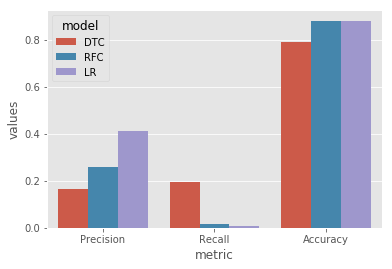

In [33]:
# Визуалищировать эти метрики всех моделей на одном графике (чтоб визуально сравнить)
# Возможно вас удивит качество! Но задача подобрана специально ;) Такое качество тоже бывает

## Your Code Here
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.barplot(x="metric", y="values", hue="model", data=metrics)

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr_DTC, tpr_DTC, thresholds_DTC = roc_curve(y_test, predict_p_DTC[:,1])
fpr_RFC, tpr_RFC, thresholds_RFC = roc_curve(y_test, predict_p_RFC[:,1])
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, predict_p_LR[:,1])

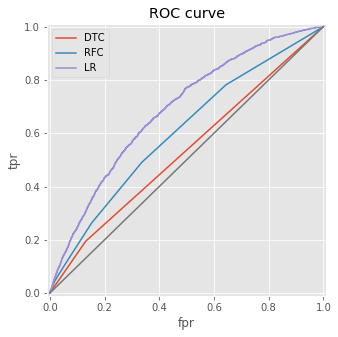

In [35]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(fpr_DTC, tpr_DTC)
plt.plot(fpr_RFC, tpr_RFC)
plt.plot(fpr_LR, tpr_LR)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.legend(['DTC', 'RFC', 'LR'])

In [36]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

rfc = RandomForestClassifier()
print(np.mean(cross_val_score(
    rfc,
    X_Train,
    y_Train,
    scoring='roc_auc',
    cv=10)))

dtc = DecisionTreeClassifier()
print(np.mean(cross_val_score(
    dtc,
    X_Train,
    y_Train,
    scoring='roc_auc',
    cv=10)))

lr = LogisticRegression()
print(np.mean(cross_val_score(
    lr,
    X_Train,
    y_Train,
    scoring='roc_auc',
    cv=10)))

0.59383593137842
0.517912190100702
0.6785036575589156


In [37]:
# Взять лучшую модель и сделать предсказания (с вероятностями (!!!)) для test выборки

model_LR = LogisticRegression()
model_LR.fit(X_Train, y_Train)
predict_LR = model_LR.predict(X_test)
predict_p_LR = model_LR.predict_proba(X_test)

0.687043117672601

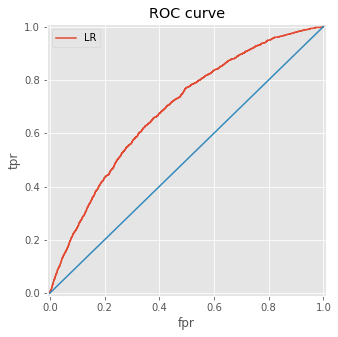

In [38]:
# Померить roc_auc на тесте
# Вывести текстом и на графике =)

plt.figure(figsize=(5, 5))
plt.plot(fpr_LR, tpr_LR)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.legend(['LR'])
roc_auc_score(y_test, predict_p_LR[:,1])
## Your Code Here

### Больше обязательных заданий нет, но ниже вы можете провести исследование, поиграться с данными
### Это возможность написать код, который я посмотрю и в случае чего откомметирую. ;)
### Это не оценивается и остается на ваше усмотрение. Просто дополнительная возможность

<span style="color:blue">**играл с данными и проиграл**</span>